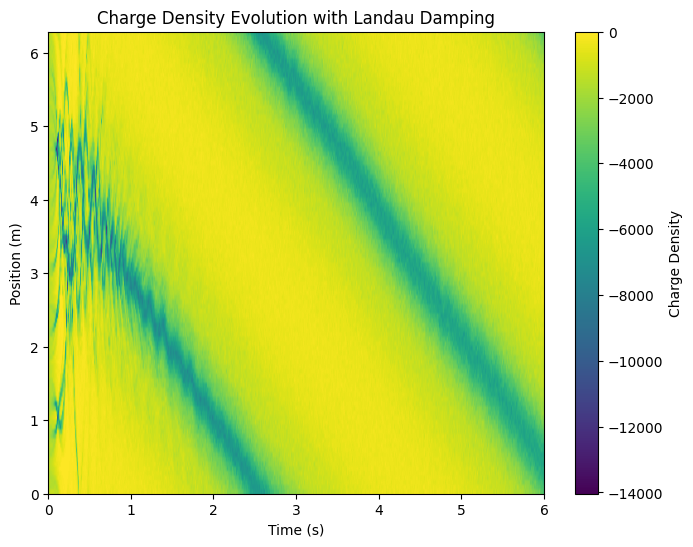

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
nx = 100                 # Number of grid points
nparticles = 10000       # Number of particles
length = 2 * np.pi       # Length of the system (m)
dx = length / nx         # Grid spacing
dt = 0.01                # Time step (s)
ntime = 600              # Number of time steps
charge = -1.0            # Charge of particles (C) (normalized)
mass = 1.0               # Mass of particles (kg) (normalized)
amplitude = 0.1          # Amplitude of the perturbation
thermal_velocity = 1.0   # Initial thermal velocity for Maxwellian distribution

# Initialize particle positions uniformly distributed between 0 and length
positions = np.random.rand(nparticles) * length

# Initialize velocities with a Maxwellian distribution
velocities = np.random.normal(0, thermal_velocity, nparticles)

# Apply a sinusoidal perturbation to the velocity distribution to induce Landau damping
velocities += amplitude * np.sin(positions)

# Initialize fields
rho = np.zeros(nx)       # Charge density grid
E = np.zeros(nx)         # Electric field grid

def assign_particles_to_grid(positions, charge):
    """Assign particles to the grid and calculate charge density."""
    rho = np.zeros(nx)
    for pos in positions:
        i = int(pos // dx)
        rho[i] += charge / dx  # Deposit charge to nearest grid point
    return rho

def solve_poisson(rho):
    """Solve Poisson's equation using periodic boundary conditions."""
    rho_hat = np.fft.rfft(rho)  # Fourier transform of charge density
    k = np.fft.rfftfreq(nx, d=dx) * 2 * np.pi
    k[0] = 1  # Avoid division by zero for k=0
    phi_hat = -rho_hat / (k**2)  # Solve Poisson in Fourier space (phi_hat = rho_hat / k^2)
    phi_hat[0] = 0  # No DC component (net charge neutrality)
    phi = np.fft.irfft(phi_hat, n=nx)  # Inverse Fourier transform to get phi
    E = -np.gradient(phi, dx)  # Electric field is the negative gradient of the potential
    return E

def interpolate_field(positions, E):
    """Interpolate the electric field from grid to particle positions."""
    E_particle = np.zeros(nparticles)
    for i, pos in enumerate(positions):
        grid_idx = int(pos // dx)
        E_particle[i] = E[grid_idx]
    return E_particle

def update_particles(positions, velocities, E_particle, charge, mass, dt):
    """Update particle velocities and positions using the Lorentz force."""
    velocities += (charge / mass) * E_particle * dt  # v = v + a * dt
    positions += velocities * dt  # x = x + v * dt
    positions = np.mod(positions, length)  # Apply periodic boundary conditions
    return positions, velocities

# Storage for charge density over time
density_time = np.zeros((ntime, nx))

# Main PIC loop
for t in range(ntime):
    # Step 1: Assign charges to the grid
    rho = assign_particles_to_grid(positions, charge)
    density_time[t, :] = rho  # Store the charge density for each time step
    
    # Step 2: Solve Poisson's equation to get electric field
    E = solve_poisson(rho)
    
    # Step 3: Interpolate electric field to particle positions
    E_particle = interpolate_field(positions, E)
    
    # Step 4: Update particle positions and velocities
    positions, velocities = update_particles(positions, velocities, E_particle, charge, mass, dt)

# Plot charge density over time as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(density_time.T, aspect='auto', cmap='viridis', extent=[0, ntime * dt, 0, length])
plt.colorbar(label='Charge Density')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Charge Density Evolution with Landau Damping')
plt.show()
